# A Level-2 Sea Ice Concentration (SIC3H) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIC3H algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceConcentration_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceConcentration_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceConcentration_ATBD/_images/SIC_concept_diagram.png" width="75%"/>

In [61]:
from importlib import reload

import sys
import os
import numpy as np
import xarray as xr

from scipy.ndimage import gaussian_filter

from matplotlib import pylab as plt
import cmocean

import cartopy.crs as ccrs

# local modules contain software code that implement the SIC algorithm
from sirrdp import rrdp_file
from pmr_sic import tiepoints as tp
from pmr_sic import algo as sic_algo
from pmr_sic import hybrid_algo

# prototype re-gridding toolbox to handle the L1B input
if '/home/thomasl/Work/DEVALGO/Tools/' not in sys.path:
    sys.path.insert(0, '/home/thomasl/Work/DEVALGO/Tools/')
from tools import io_handler as io
from tools import collocation as coll

## Parametrize the run

Here we decide on some values that yield for the whole notebook

In [2]:
rrdp_dir = './sirrdp'
area = 'nh'
algos = dict()
algos['CKA'] = {'channels':('tb06v', 'tb37v', 'tb37h'), 'target_band':'C'}
algos['KUKA'] = {'channels':('tb19v', 'tb37v', 'tb37h'), 'target_band':'KU'}
algos['KA'] = {'channels':('tb37v', 'tb37h'),  'target_band':'KA'}

# Change location where you stored the L1B file
l1b_path = '/home/thomasl/Documents/DEVALGO/Simul_L1B_20230421/'
# DEVALGO's simulated geometric test card
l1b_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
# DEVALGO's simulated radiometric test card
l1b_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
proj = 'nh'

l1b_fn = os.path.join(l1b_path,l1b_fn)

## Off-line preparation : Tune the SIC algorithms

The SIC algorithms `CKA`, `KUKA`, and `KA` require tuning before they can be run to compute SIC. The tuning step involves the preparation of the OW (Open Water, 0% SIC) and CI (Consolidated Ice, 100% SIC) tie-points, as well as the optimization of the algorithm parameters, to fit the training data best.

In this implementation of the algorithm, the training data are taken from the ESA CCI Sea Ice Concentration Round Robin Data Package of Pedersen et al. (2019). The relevant data files as well as routines to parse the files are stored in module `siddrp/`.

Pedersen, Leif Toudal; Saldo, Roberto; Ivanova, Natalia; Kern, Stefan; Heygster, Georg; Tonboe, Rasmus; et al. (2019): Reference dataset for sea ice concentration. figshare. Dataset. https://doi.org/10.6084/m9.figshare.6626549.v7

In an operational setup, this tuning should happen approximately every day and be based on dynamically loaded TB data (e.g. over the last 7 days). This does not need to run again for each new incoming L1B file.

### Load the OW and CI training data (from ESA CCI RRDP)

In [3]:
reload(rrdp_file)
ow_files, ci_files = rrdp_file.find_rrdp_files(rrdp_dir, area=area, years=(2007, 2013, 2018))

channels_needed = []
for alg in algos.keys():
    channels_needed += algos[alg]['channels']
channels_needed = set(channels_needed)

rrdp_pos = rrdp_file.read_RRDP_files(area, ow_files, ci_files, channels=channels_needed)

Number of OW samples:  15955
Number of CI samples:  13441


Transfer the training data in a tie-point object. This involves some processing, like computing the tie-points and their covariance matrices. 

In [4]:
ow_tp = tp.OWTiepoint(source='rrdp', tbs=rrdp_pos['ow'])
ci_tp = tp.CICETiepoint(source='rrdp', tbs=rrdp_pos['ci'])

Select every 1 OW points
Select every 10 CICE points


### Tune the CKA, KUKA, and KA algorithms on the training data

In [5]:
for alg in algos.keys():
    print("Tune {}".format(alg,))
    algos[alg]['algo'] = hybrid_algo.HybridSICAlgo(algos[alg]['channels'], ow_tp, ci_tp)


Tune CKA
Tune KUKA
Tune KA


## Step 1: Load the L1B files and prepare remapped TB arrays for each algo

The three algorithms `CKA`, `KUKA`, and `KA` combine different microwave channels (e.g. `CKA` combines C-Vpol, KA-Vpol, and KA-Hpol). Since each frequency channel is not sampled at the same location nor resolution, we must prepare location-matched, resolution-matched TB arrays for each algorithm.

In this version of the algorithm, we prepare TB arrays at the spatial resolution of the coarsest channel (e.g. we prepare C-Vpol, KA-Vpol, and KA-Hpol to the resolution of C-Vpol as input to the `CKA` algorithm).

This remapping is handled by software in the `Tools/` repository (a prototype CIMR Regridding Toolbox developed in the CIMR DEVALGO study).

In [6]:
# global definitions
tb_dict = {'tb01':'L','tb06':'C','tb10':'X','tb19':'KU','tb37':'KA',}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

In [7]:
# read L1B. We only read the bands needed for the three algorithms
reload(io)
full_l1b = io.CIMR_L1B(l1b_fn, selected_bands=bands_needed, keep_calibration_view=True)

In [8]:
# align scalines using the scan angle offset
full_l1b.align_arrays_to_start_at_zero_scan_angle()

# coarsen l1b samples along the scanlines with a kernel of 5 (horns are *not* combined)
coarsen_l1b = full_l1b.coarsen_along_scanlines(kernel=5)

# split into forward / backward scan
fwd_l1b, bck_l1b = coarsen_l1b.split_forward_backward_scans(method='horn_scan_angle')

# reshape by interleaving the feeds 
reshaped_fwd_l1b = fwd_l1b.reshape_interleave_feed()
reshaped_bck_l1b = bck_l1b.reshape_interleave_feed()

# Collocate the channels with a nearest neighbour approach. This step covers both the
#   definition of the target grid, and the remapping. Use the correct 'target_band' for
#   each algorithm.
fwd_l1x = dict()
bck_l1x = dict()
for alg in algos.keys():
    fwd_l1x[alg] = coll.collocate_channels(reshaped_fwd_l1b.data, algos[alg]['target_band'], method='nn')
    bck_l1x[alg] = coll.collocate_channels(reshaped_bck_l1b.data, algos[alg]['target_band'], method='nn')

## Step 2: Apply the 3 algos to compute intermediate SICs

This applies the three algorithms on their respective TB arrays (obtained from the L1B remapping of the TBs). The SIC algorithms are applied separately for the forward and backward scan of the swath.

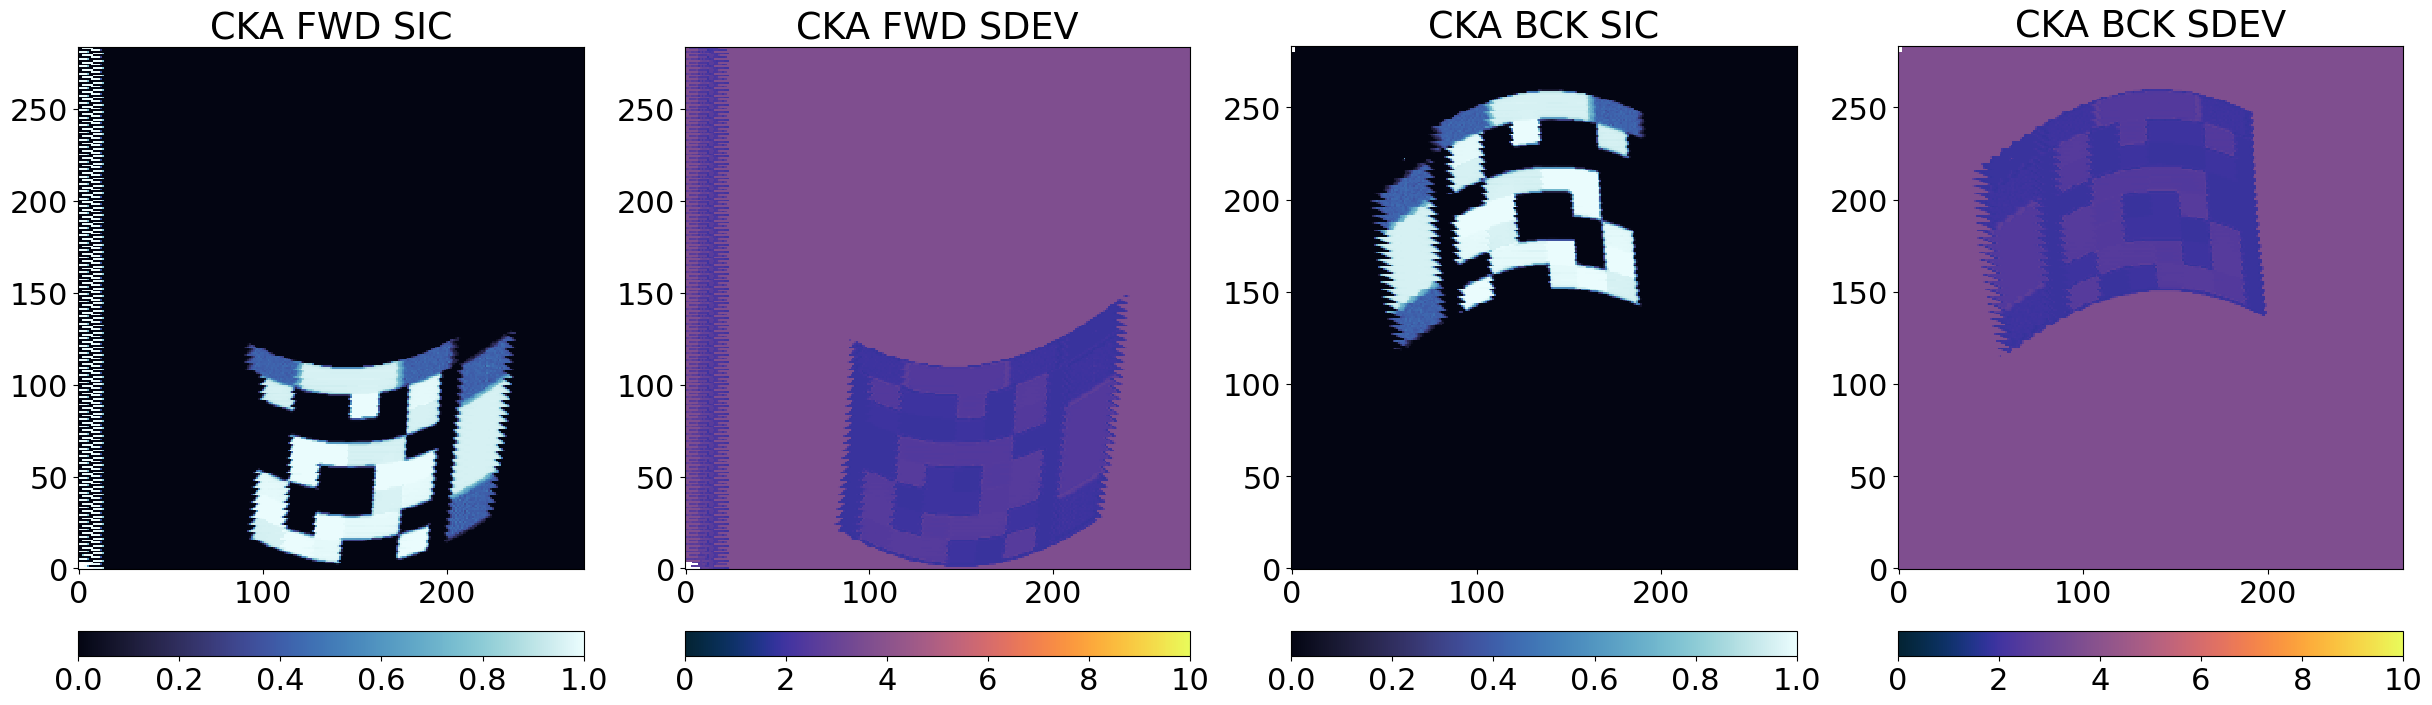

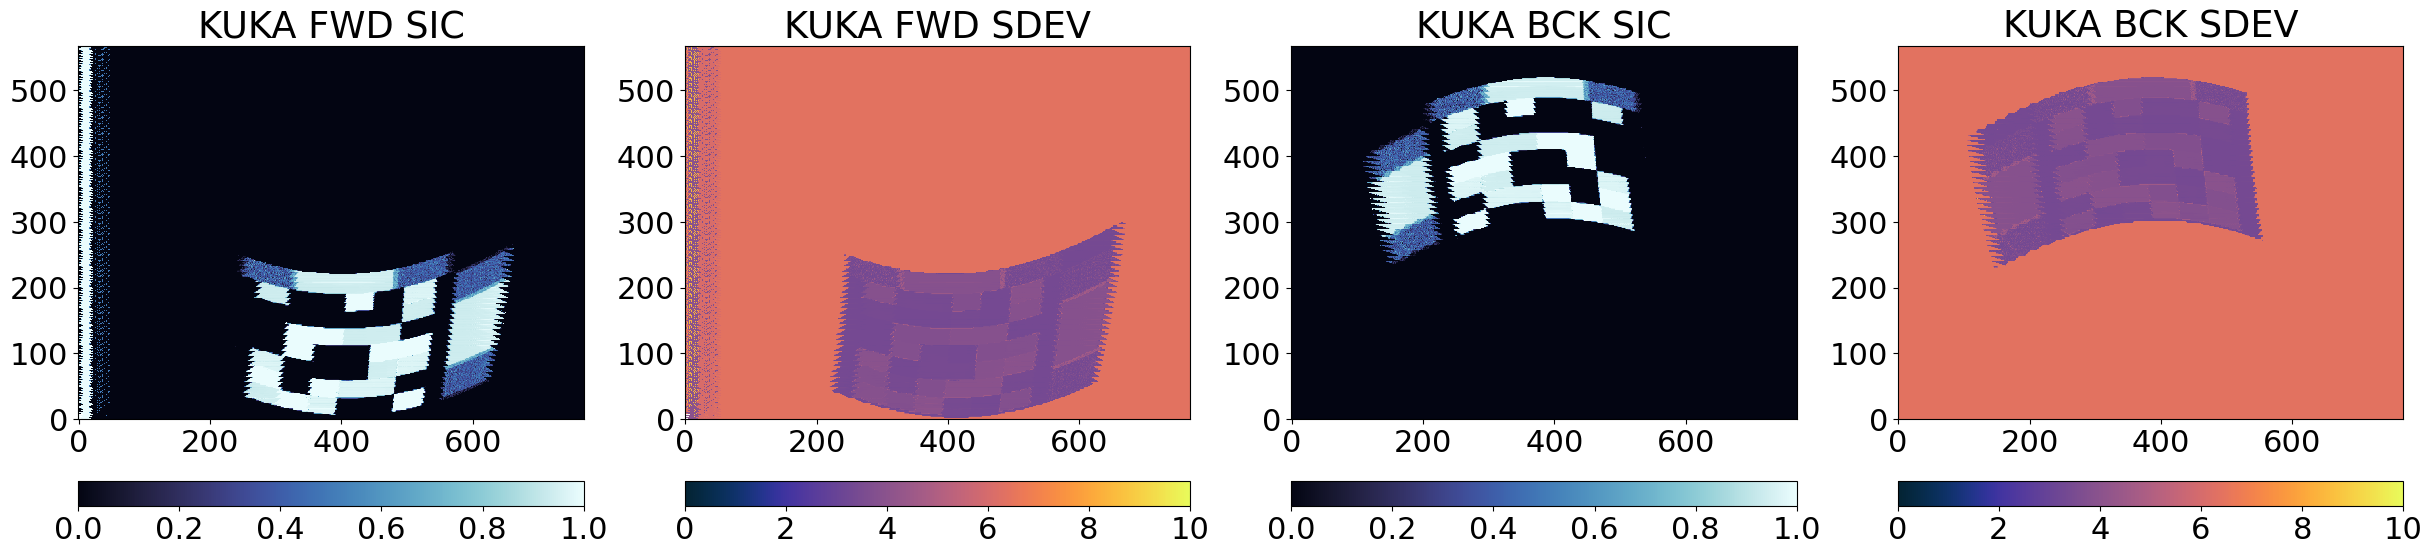

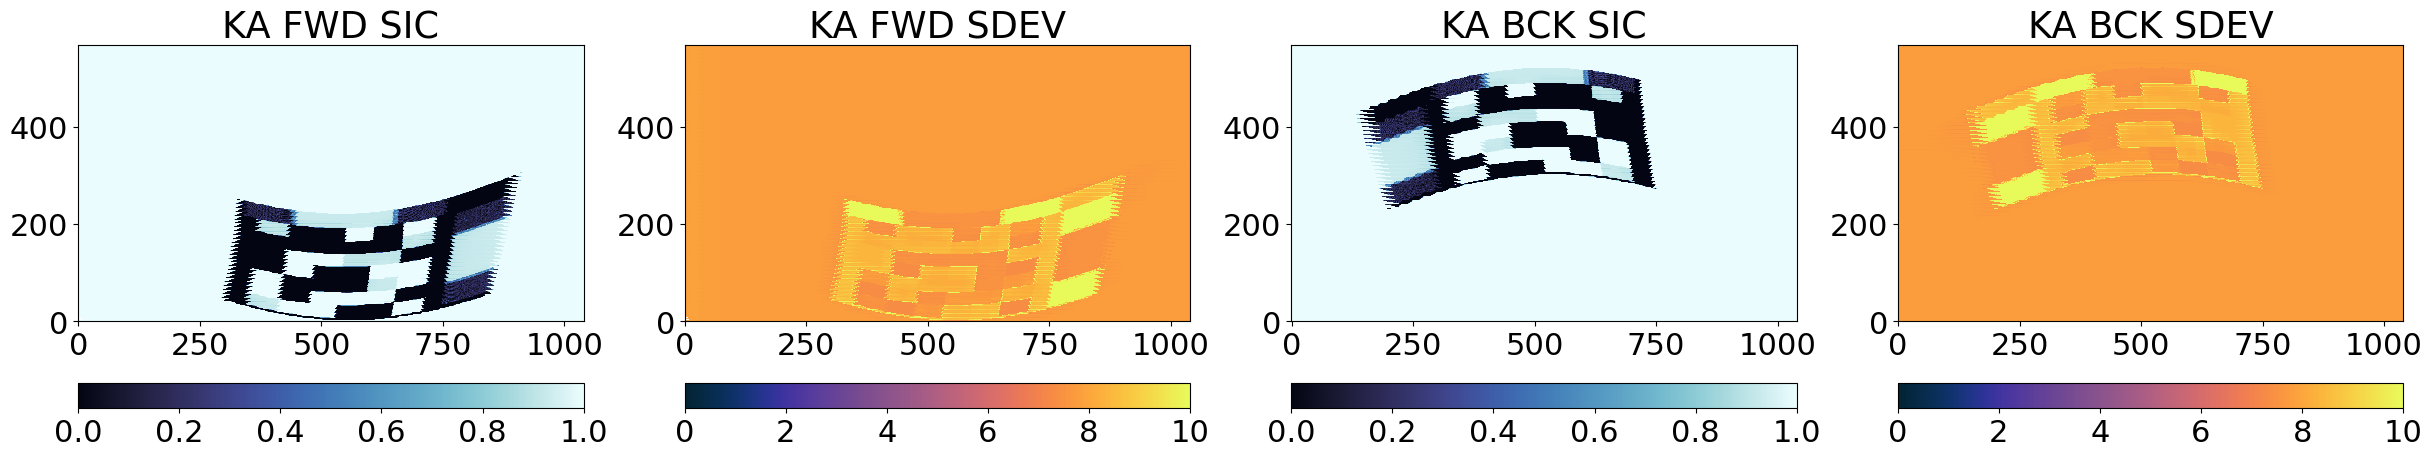

In [9]:
fwd_res = dict()
bck_res = dict()
for alg in algos.keys():
    
    # prepare TBs in the structure expected as input to the algorithm
    fwd_tbs = dict()
    bck_tbs = dict()
    for ch in algos[alg]['channels']:
        band = tb_dict[ch[:-1]] + '_BAND'
        varn = 'brightness_temperature_'+ch[-1]
        fwd_tbs[ch] = fwd_l1x[alg][band][varn].values
        bck_tbs[ch] = bck_l1x[alg][band][varn].values
    
    # run the algorithm to compute SIC
    fwd_res[alg] = algos[alg]['algo'].compute_sic(fwd_tbs)
    bck_res[alg] = algos[alg]['algo'].compute_sic(bck_tbs)
    
    # Simple visualization in swath L1X geometry

    cmap = cmocean.cm.ice
    ucmap = cmocean.cm.thermal
    vmin, vmax = (0, 1)
    umin, umax = (0, 10)
    
    fig = plt.figure(figsize=(30,16))
    axF = fig.add_subplot(1,4,1)
    cF = axF.imshow(fwd_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axF.set_title(alg + " " + "FWD" + " " + "SIC")
    plt.colorbar(cF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,2, sharex=axF, sharey=axF)
    uF = ax.imshow(fwd_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "FWD" + " " + "SDEV")
    plt.colorbar(uF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    axB = fig.add_subplot(1,4,3)
    cB = axB.imshow(bck_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axB.set_title(alg + " " + "BCK" + " " + "SIC")
    plt.colorbar(cB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,4, sharex=axB, sharey=axB)
    uB=ax.imshow(bck_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "BCK" + " " + "SDEV")
    plt.colorbar(uB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])


From the images above, it is clear that the three algorithms see high and low concentrations in the same locations in the Test Card, which means they are returning related SIC fields that we can later combine. The uncertainties (SDEV) are as expected lower for `CKA` than for `KUKA` that are lower than those of `KA`.

## Step 3 : Pan-sharpening and computation of "final" Level-2 SIC

The third step deploys a pan-sharpening methodology to combine pairs of intermediate SICs into the final Level-2 SICs. In our case, the ‘base’ image can be the high-accuracy / coarse-resolution intermediate SIC from `CKA` and the ‘sharpener’ image can be the low-accuracy / fine-resolution intermediate SIC from `KA`. This results in a final SIC named `CKA@KA`.

The ATBD calls for more such pan-sharpening to happen, but for the time being we focus on `CKA@KA`.

The pansharpening equation is simply
$$
\begin{array}{lc}
C_{ER} &=& \textrm{Remap}_{HR}(C_{LR}) +  \Delta_{edges} \\
       &=& \textrm{Remap}_{HR}(C_{LR}) + ( C_{HR} - C_{HR, blurred} ) \\ 
\end{array}
$$

where suffix "ER" refers to enhanced resolution (the final SIC), "LR" to "low resolution" (the 'base' SIC to be pan-sharpened),
and "HR" to "high resolution" (the 'sharpener' SIC). The equation also involves $C_{HR, blurred}$ which is C_{HR} blurred to
the spatial resolution of $C_{LR}$. The quantity $( C_{HR} - C_{HR, blurred})$ is sometimes referred to as a $\Delta_{edges}$ as it takes
small values everywhere but in the regions where $C_{HR}$ exhibits sharp gradients (e.g. in the Marginal Ice Zone). The $\textrm{Remap}_{HR}$ operator
remaps the location (only the location, not the resolution) of $C_{LR}$ to those of $C_{HR}$ to enable adding the two fields together. The resulting SIC field, $C_{ER}$ is
thus at the locations of $C_{HR}$, with the spatial resolution of $C_{HR}$ and the accuracy of $C_{LR}$ (if the pan-sharpening works perfectly).

There are thus 3 steps for building the pan-sharpened SIC $C_{ER}$:
1. Regrid 'base' SIC (coarse resolution) to 'sharpener' SIC (high resolution) grid
2. Prepare the 'blurred' sharpener SIC field
3. Compute $\Delta_{edges}$ and finally $C_{ER}$


### Step 3.1 Regrid 'base' SIC (coarse resolution) to 'sharpener' SIC (high resolution) grid 
A first intermediate step is to have the base SIC field (e.g. `CKA`) on the same grid as the sharpener grid `KA`. For this we use some of our collocation tools in the toolbox. 

In [10]:
algo = 'CKA@KA'
base, sharpener = algo.split('@')

In [11]:
reload(coll)
# extract target and source geometries
fwd_trg_lon = fwd_l1x[sharpener]['geolocation']['lon'].to_numpy()
fwd_trg_lat = fwd_l1x[sharpener]['geolocation']['lat'].to_numpy()
fwd_src_lon = fwd_l1x[base]['geolocation']['lon'].to_numpy()
fwd_src_lat = fwd_l1x[base]['geolocation']['lat'].to_numpy()
bck_trg_lon = bck_l1x[sharpener]['geolocation']['lon'].to_numpy()
bck_trg_lat = bck_l1x[sharpener]['geolocation']['lat'].to_numpy()
bck_src_lon = bck_l1x[base]['geolocation']['lon'].to_numpy()
bck_src_lat = bck_l1x[base]['geolocation']['lat'].to_numpy()
# Prepare a stack of the data to be regridded (e.g. SIC and SDEV)
what = ('sic','sdev','dal','owf')
fwd_stack_shape = tuple(list(fwd_src_lat.shape) + [len(what),])
bck_stack_shape = tuple(list(bck_src_lat.shape) + [len(what),])
fwd_src_stack = np.empty(fwd_stack_shape)
bck_src_stack = np.empty(bck_stack_shape)
for iw, w in enumerate(what):
    fwd_src_stack[...,iw] = fwd_res[base].get(w)
    bck_src_stack[...,iw] = bck_res[base].get(w)

# regrid and get _bAs (base @ sharpener grid), 
_fwd_bAs = coll._regrid_fields(fwd_trg_lon, fwd_trg_lat, fwd_src_lon, fwd_src_lat, fwd_src_stack)
_bck_bAs = coll._regrid_fields(bck_trg_lon, bck_trg_lat, bck_src_lon, bck_src_lat, bck_src_stack)

# store in an object
fwd_res[algo + '(bAs)'] = sic_algo.SICAlgoResult(_fwd_bAs[...,0], _fwd_bAs[...,1], _fwd_bAs[...,2], _fwd_bAs[...,3])
bck_res[algo + '(bAs)'] = sic_algo.SICAlgoResult(_bck_bAs[...,0], _bck_bAs[...,1], _bck_bAs[...,2], _bck_bAs[...,3])

In [12]:
# The bAs now has the same shape as the sharpener
assert(fwd_res[sharpener].sic.shape == fwd_res[algo+'(bAs)'].sic.shape)
assert(bck_res[sharpener].sic.shape == bck_res[algo+'(bAs)'].sic.shape)

### Step 3.2 Prepare the 'blurred' sharpener SIC field 

Second intermediate step is to prepare a blurred version of the sharpener SIC field, keeping it in its own grid (each grid point in the blurred SIC field is computed from the surrounding pixels in the field). The aim is to blur the 'sharpener' SIC until a resolution similar to that of the 'base' SIC (but to stay in the 'sharpener' grid).


In [13]:
reload(coll)

# extract target and source geometries (the same: we stay in the sharpener's grid)
fwd_trg_lon = fwd_l1x[sharpener]['geolocation']['lon'].to_numpy()
fwd_trg_lat = fwd_l1x[sharpener]['geolocation']['lat'].to_numpy()
fwd_src_lon = fwd_l1x[sharpener]['geolocation']['lon'].to_numpy()
fwd_src_lat = fwd_l1x[sharpener]['geolocation']['lat'].to_numpy()
bck_trg_lon = bck_l1x[sharpener]['geolocation']['lon'].to_numpy()
bck_trg_lat = bck_l1x[sharpener]['geolocation']['lat'].to_numpy()
bck_src_lon = bck_l1x[sharpener]['geolocation']['lon'].to_numpy()
bck_src_lat = bck_l1x[sharpener]['geolocation']['lat'].to_numpy()
# Prepare a stack of the data to be regridded (only the SIC)
what = ('sic',)
fwd_stack_shape = tuple(list(fwd_src_lat.shape) + [len(what),])
bck_stack_shape = tuple(list(bck_src_lat.shape) + [len(what),])
fwd_src_stack = np.empty(fwd_stack_shape)
bck_src_stack = np.empty(bck_stack_shape)
for iw, w in enumerate(what):
    fwd_src_stack[...,iw] = fwd_res[sharpener].get(w)
    bck_src_stack[...,iw] = bck_res[sharpener].get(w)

# regrid and get _sbl (sharpener blurred)
params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
_fwd_sbl = coll._regrid_fields(fwd_trg_lon, fwd_trg_lat, fwd_src_lon, fwd_src_lat, fwd_src_stack, params=params)
_bck_sbl = coll._regrid_fields(bck_trg_lon, bck_trg_lat, bck_src_lon, bck_src_lat, bck_src_stack, params=params)


# store in an object
fwd_res[algo + '(blur)'] = sic_algo.SICAlgoResult(_fwd_sbl[...,0], fwd_res[sharpener].sdev, fwd_res[sharpener].dal, fwd_res[sharpener].owf)
bck_res[algo + '(blur)'] = sic_algo.SICAlgoResult(_bck_sbl[...,0], bck_res[sharpener].sdev, bck_res[sharpener].dal, bck_res[sharpener].owf)

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 55 neighbours within 62500.0 m for some data points
  warnings.warn(('Possible more than %s neighbours '


### Step 3.3 Compute $\Delta_{edges}$ and finally $C_{ER}$

This is the final step of the pan-sharpening. We first compute $\Delta_{edges} = C_{HR} - C_{HR, blurred}$, then the final enhance-resolution SIC $C_{ER}$.

In [14]:
# compute the delta edges
_fwd_delta = fwd_res[sharpener].sic - fwd_res[algo + '(blur)'].sic
_bck_delta = bck_res[sharpener].sic - bck_res[algo + '(blur)'].sic

# store in an object (intermediate result, we store it only for visualization in the notebook)
_fwd_zeros = np.zeros_like(_fwd_delta)
_bck_zeros = np.zeros_like(_bck_delta)
fwd_res[algo + '(delta)'] = sic_algo.SICAlgoResult(_fwd_delta, _fwd_zeros, _fwd_zeros, _fwd_zeros)
bck_res[algo + '(delta)'] = sic_algo.SICAlgoResult(_bck_delta, _bck_zeros, _bck_zeros, _bck_zeros)

In [15]:
# compute final pan-sharpened SIC
_fwd_er = fwd_res[algo+'(bAs)'].sic + _fwd_delta
_bck_er = bck_res[algo+'(bAs)'].sic + _bck_delta

# store in an object
_fwd_zeros = np.zeros_like(_fwd_delta)
_bck_zeros = np.zeros_like(_bck_delta)
fwd_res[algo] = sic_algo.SICAlgoResult(_fwd_er, fwd_res[algo+'(bAs)'].sdev, _fwd_zeros, _fwd_zeros)
bck_res[algo] = sic_algo.SICAlgoResult(_bck_er, bck_res[algo+'(bAs)'].sdev, _bck_zeros, _bck_zeros)

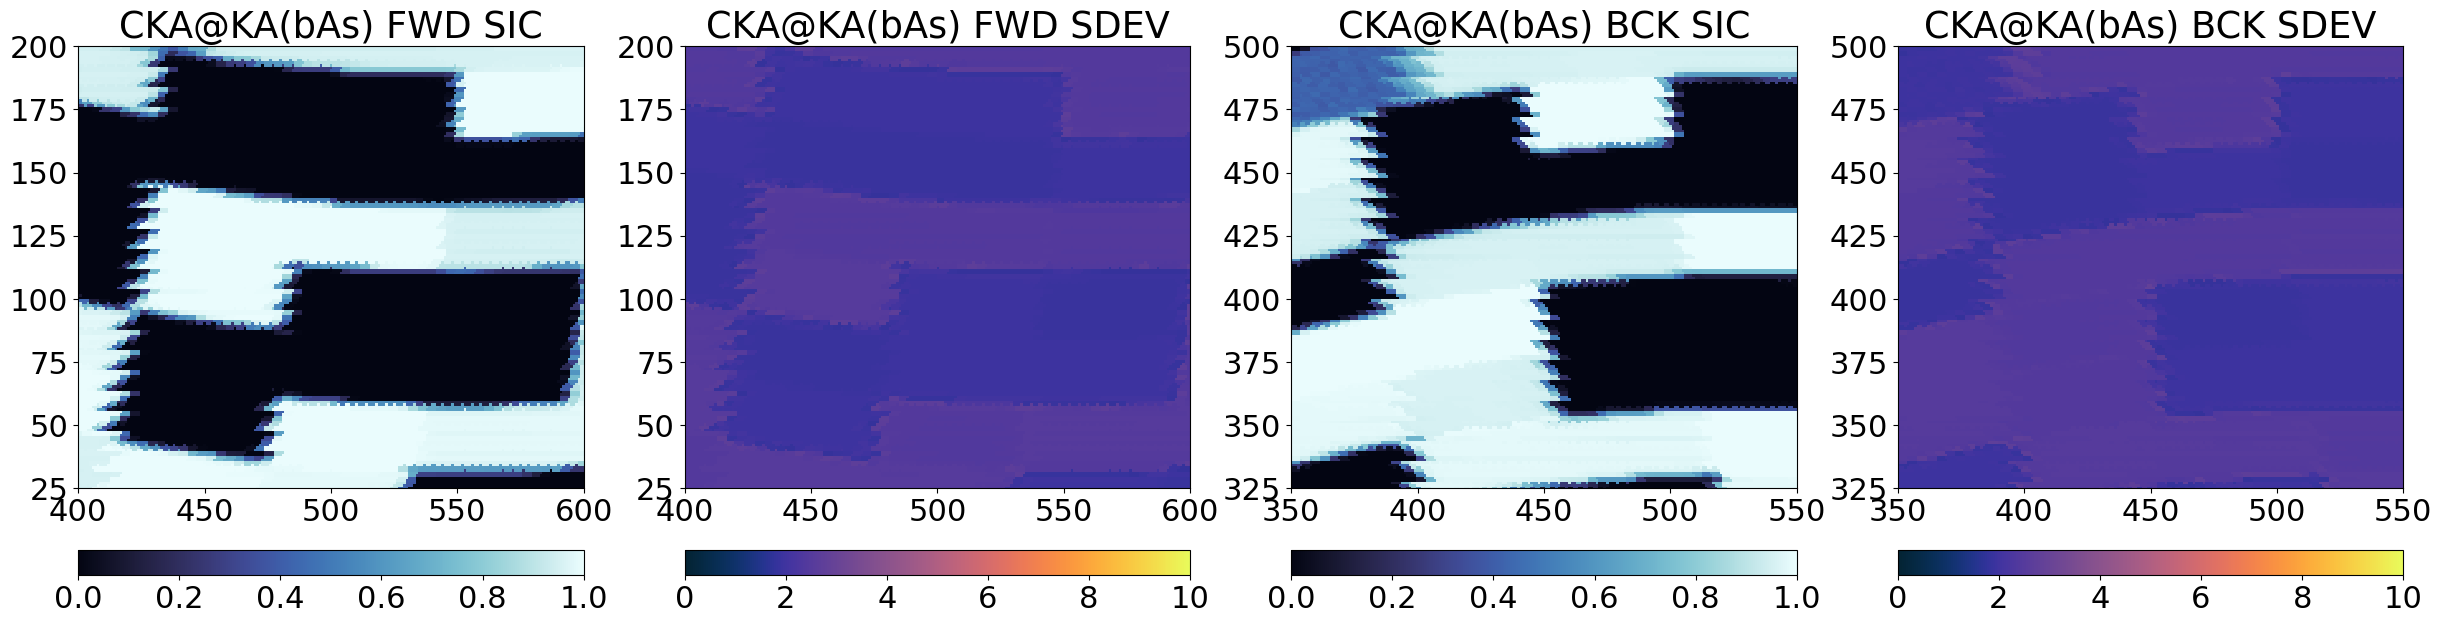

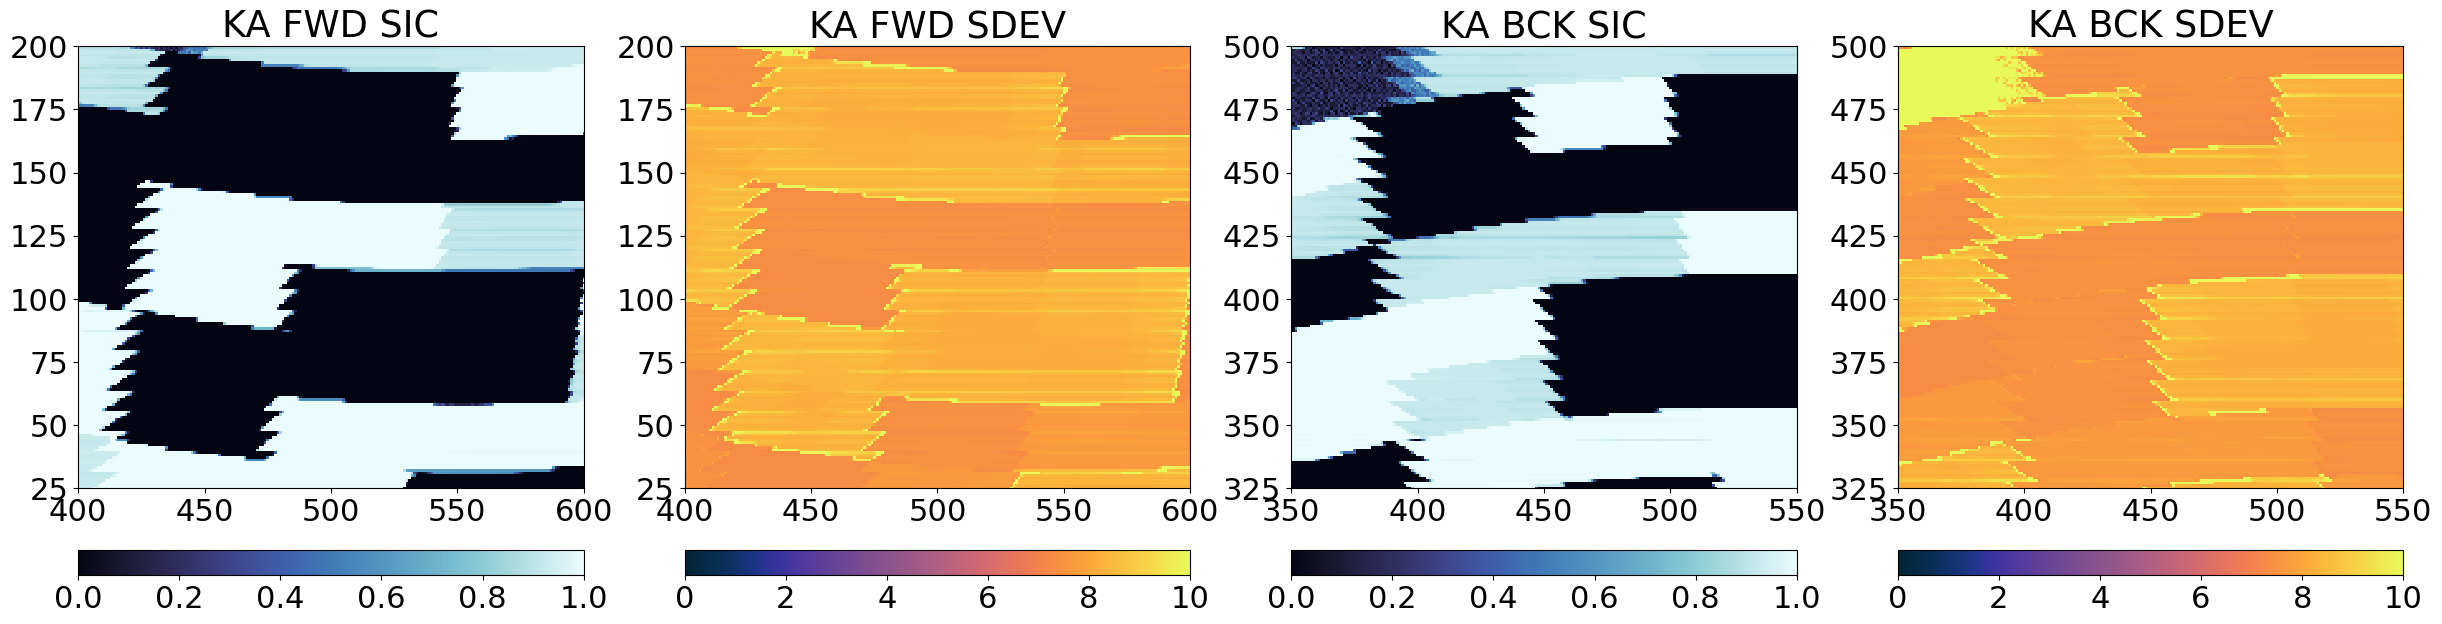

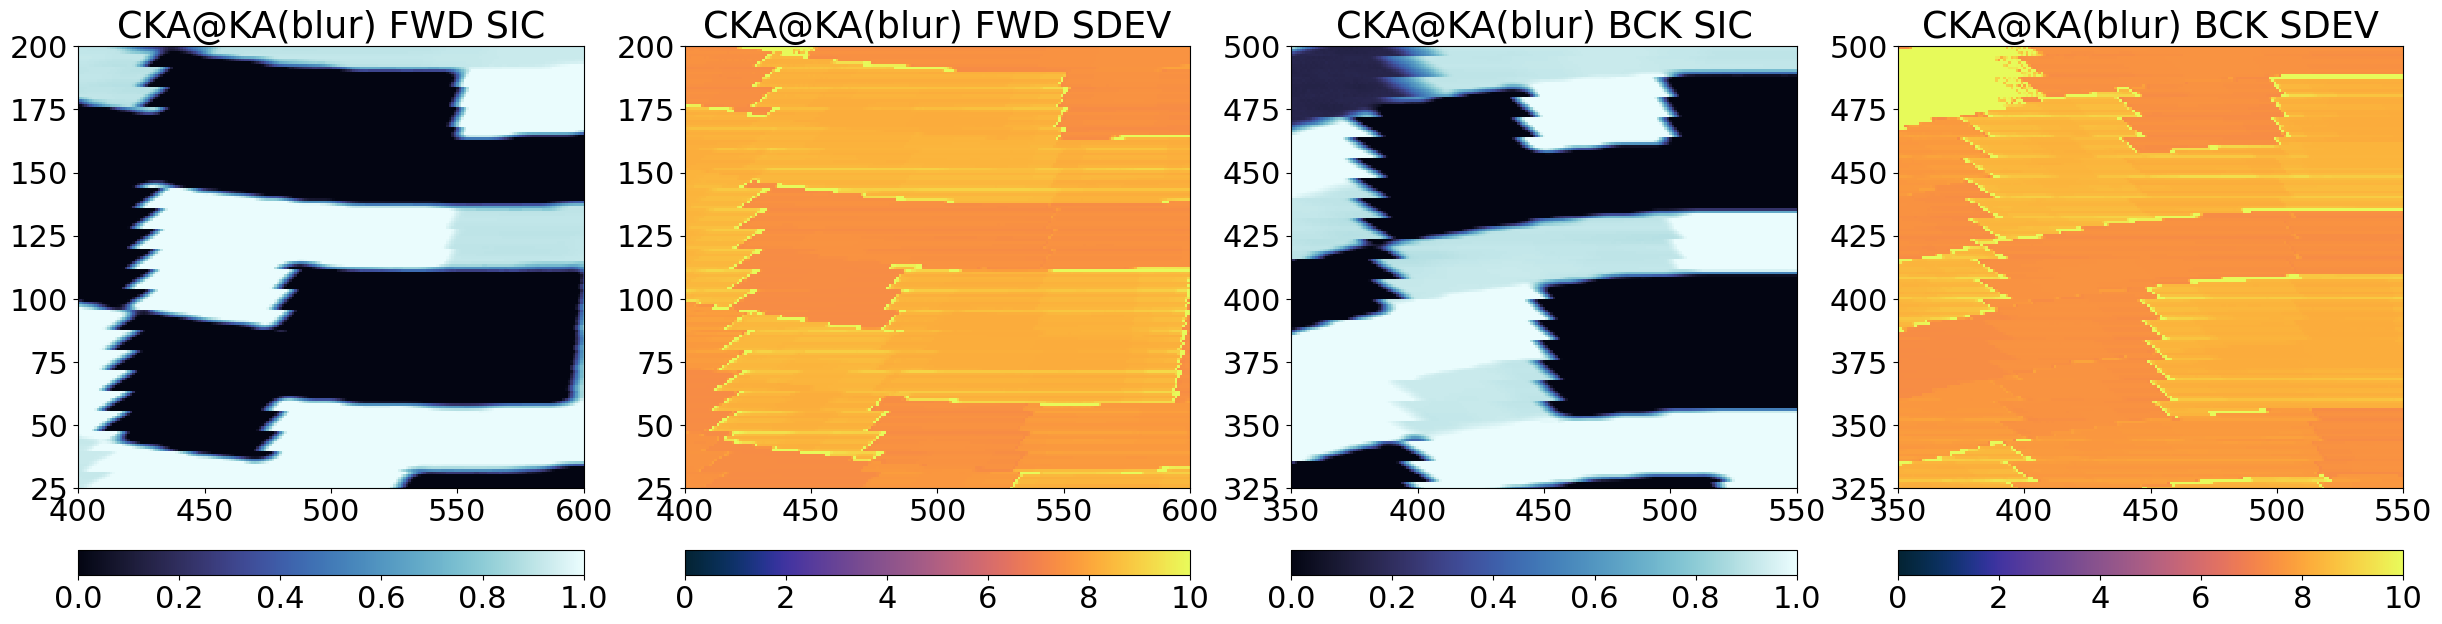

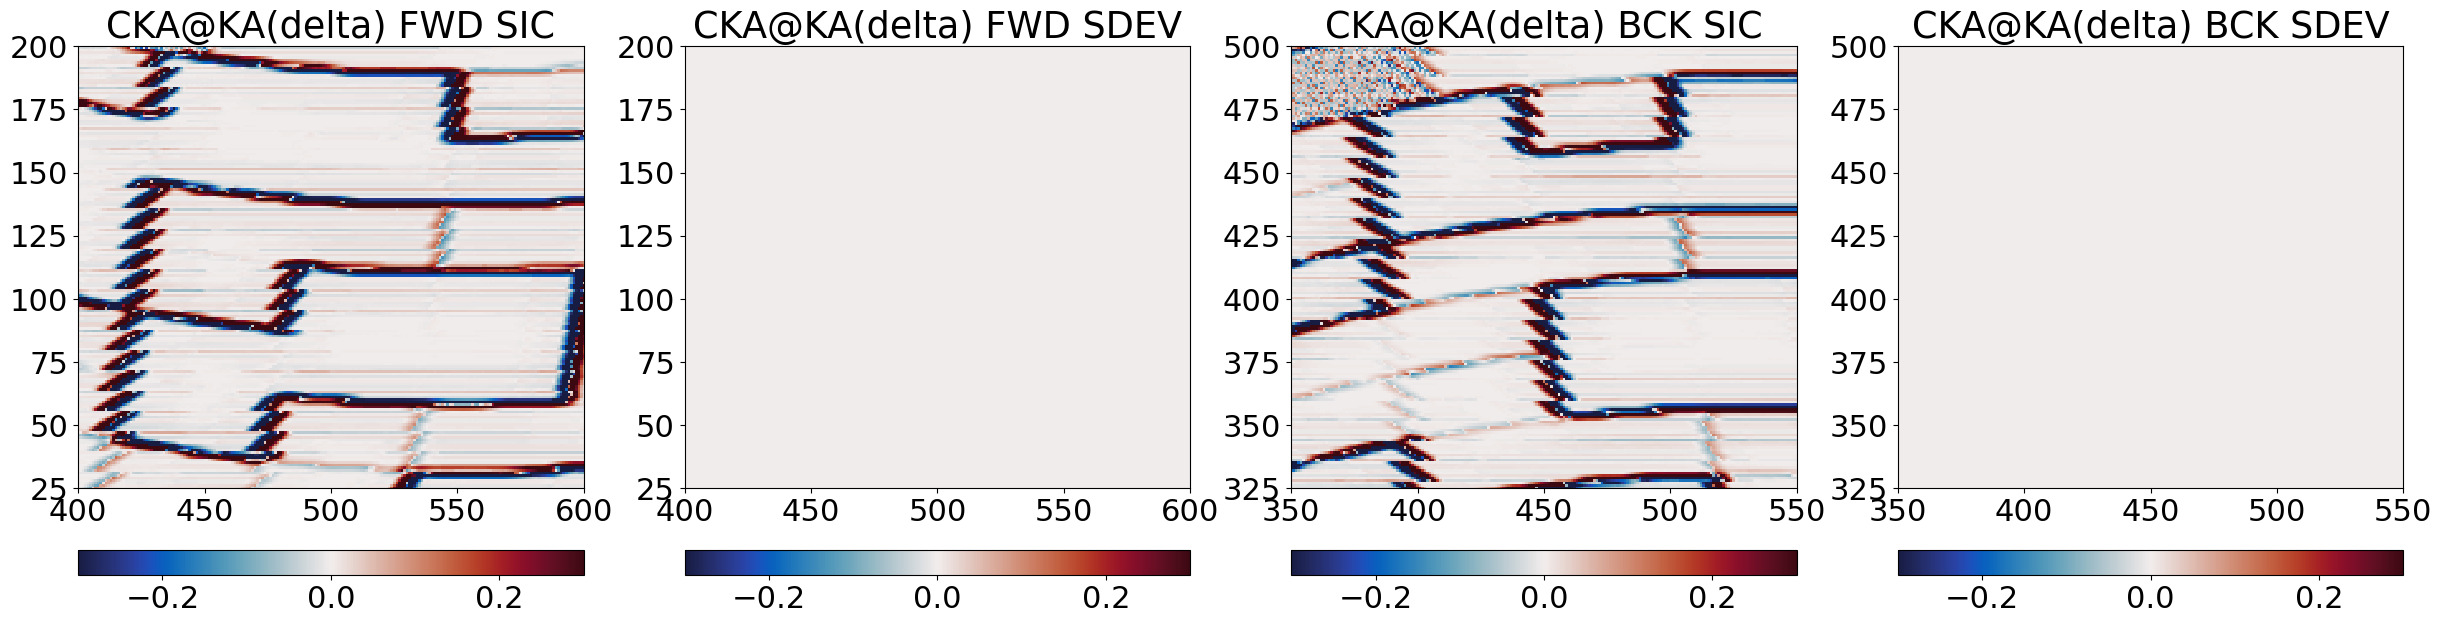

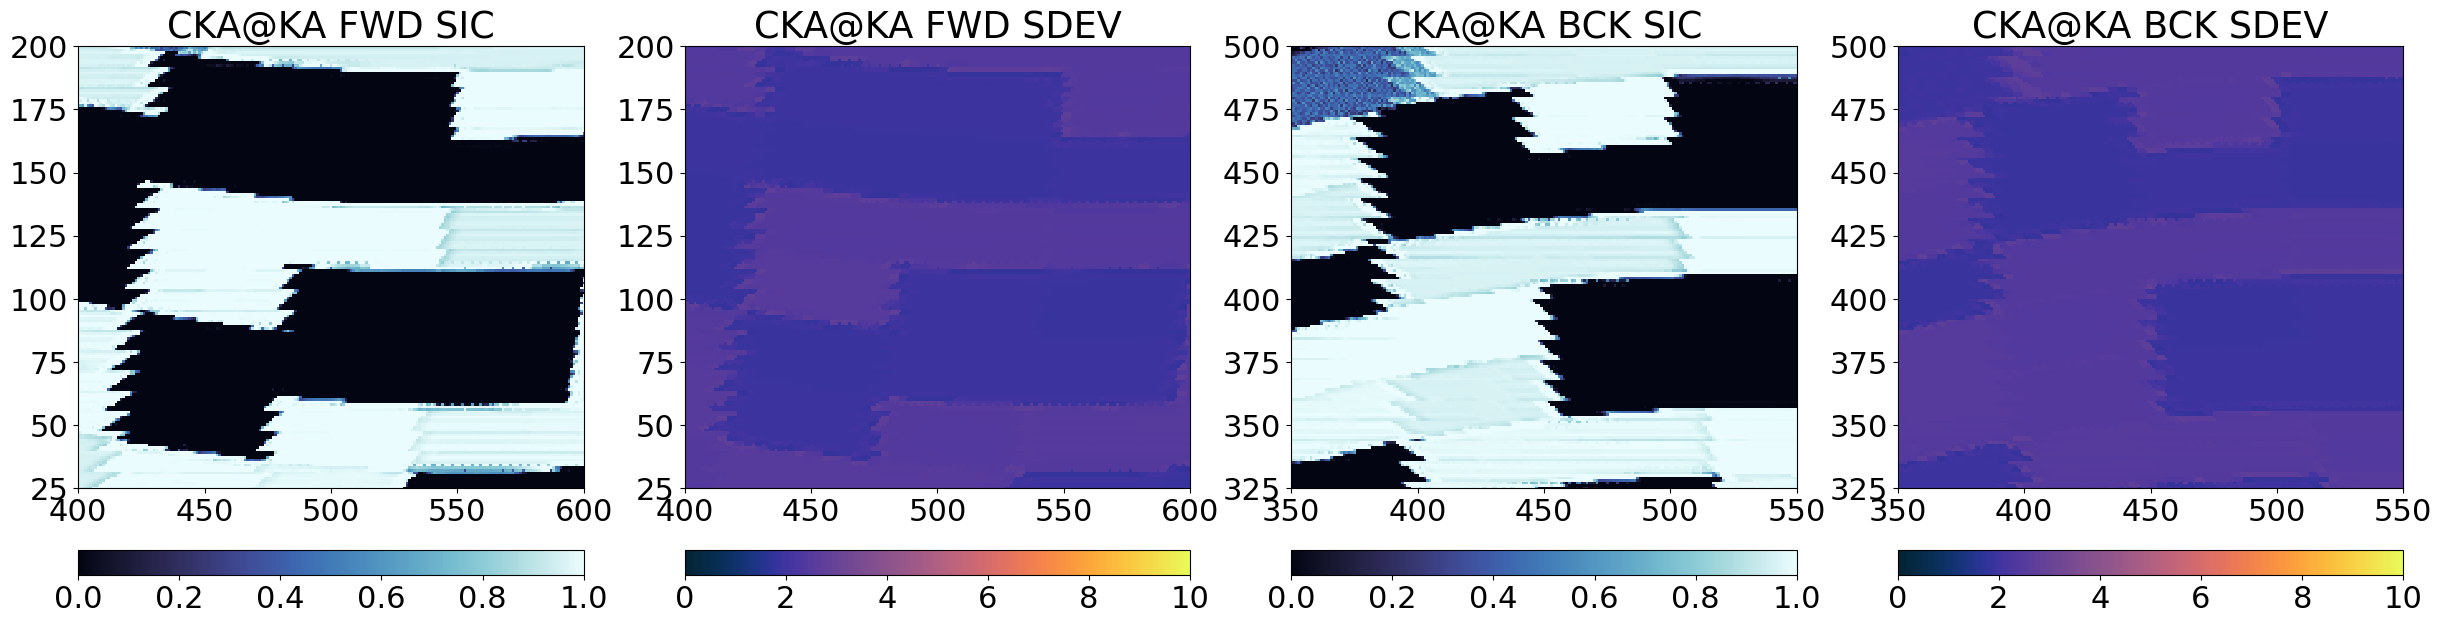

In [16]:
# Simple visualization in swath L1X geometry
for alg in (algo + '(bAs)', sharpener, algo + '(blur)', algo + '(delta)', algo):
    cmap = cmocean.cm.ice
    ucmap = cmocean.cm.thermal
    vmin, vmax = (0, 1)
    umin, umax = (0, 10)
    if 'delta' in alg:
        cmap = cmocean.cm.balance
        ucmap = cmap
        vmin, vmax = (-0.3, 0.3)
        umin, umax = (vmin, vmax)
    fig = plt.figure(figsize=(30,16))
    axF = fig.add_subplot(1,4,1)
    cF = axF.imshow(fwd_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axF.set_title(alg + " " + "FWD" + " " + "SIC")
    plt.colorbar(cF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,2, sharex=axF, sharey=axF)
    uF = ax.imshow(fwd_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "FWD" + " " + "SDEV")
    plt.colorbar(uF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    axB = fig.add_subplot(1,4,3)
    cB = axB.imshow(bck_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axB.set_title(alg + " " + "BCK" + " " + "SIC")
    plt.colorbar(cB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,4, sharex=axB, sharey=axB)
    uB=ax.imshow(bck_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "BCK" + " " + "SDEV")
    plt.colorbar(uB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    
    axF.set_xlim(400,600)
    axF.set_ylim(25,200)
    axB.set_xlim(350,550)
    axB.set_ylim(325,500)
    
    plt.show()


## Step 4 : Combine forward and backward scans

For the time being, we resample the SICs from the forward and the backward scans (separately) to an EASE2 grid, then combine them on the grid. We define a status_flag to record if a particular grid cell is from forward+backward scans, only forward, or only backward.

Note: in this implementation we only regrid to the Northern Hemisphere grid because we know that the simulated L1B orbit does not extend over the Southern Hemisphere. In general, orbits can cover both hemisphere and we will have to grid each orbit both to an NH and and SH grid.

### Step 4.1 : Load the grid definition from parameter file

In [81]:
from pyresample import parse_area_file

grid_def_file = os.path.join('grids_py.def')

algo = 'CKA@KA'
base, sharpener = algo.split('@')
# this is the mean spacing of the SIC field, which is about 4000m for @KA
src_spacing = 4000

# First alternative : grid to a pan-Arctic EASE2 grid 
grid_n = 'nh-ease2-025'
adef  = parse_area_file(grid_def_file, grid_n)[0]
trg_lon, trg_lat = adef.get_lonlats()
trg_spacing = 2500

In [85]:
# Second alternative : grid to the same grid as the TestCard
ds = xr.open_dataset('/home/thomasl/Downloads/test_scene_2_compressed_lowres.nc')
trg_lon = ds['Longitude'].data
trg_lat = ds['Latitude'].data
trg_spacing = 1000

# Reverse-engineer a pyresample AreaDefinition object for the TestCards since
#   this is not encoded in the file
import pyproj
import pyresample as pr

# define a pyproj CRS for the EAES2 grid
tc_epsg = '6931'
crs_tc = pyproj.CRS.from_epsg(int(tc_epsg))

# compute corner coordinates from the corners of the lat/lon array
crs_latlon = pyproj.CRS('+proj=latlong +ellps=WGS84')
t = pyproj.transformer.Transformer.from_crs(crs_latlon, crs_tc)
#nsidc_lon = (ds_icdc['lon'].data + 180) % 360 - 180
#nsidc_lon[nsidc_lon==-180] = +180
#nsidc_lat = ds_icdc['lat'].data
x0,y0 = t.transform(trg_lon[0,0], trg_lat[0,0],)
print(x0,y0)
x1,y1 = t.transform(trg_lon[1,1], trg_lat[1,1],)
xe,ye = t.transform(trg_lon[-1,-1], trg_lat[-1,-1],)
sx = x1-x0
sy = y1-y0

print(sx, sy)

# prepare the pyresample AreaDefinition object
area_extent = [x0-0.5*sx, y0-0.5*sy, xe+0.5*sx, ye+0.5*sy, ]
print(area_extent)

shape = trg_lon.shape
adef_tc = pr.geometry.AreaDefinition('ease25','ease25','ease25', 'EPSG:'+tc_epsg,
                          shape[1], shape[0], area_extent)
# check we have it correct:
lons, lats = adef_tc.get_lonlats()
print('max difference in lon:', abs(lons-trg_lon).max())
print('min difference in lat:', abs(lats-trg_lat).max())

#fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
#ax[0,0].imshow(trg_lon, interpolation='none')
#ax[1,0].imshow(lons, interpolation='none')
#ax[0,0].set_title('Lons')
#ax[0,1].imshow(trg_lat, interpolation='none')
#ax[1,1].imshow(lats, interpolation='none')
#ax[0,1].set_title('Lats')
#plt.show()

print("pyresample AreaDefinition for the TestCard:")
print(adef_tc)
adef = adef_tc

500.0000767343946 -1499500.1891249667
999.99965845959 1000.4368629008532
[0.00024750459959932414, -1500000.4075564172, 1399999.6929775781, -99999.76054576537]
max difference in lon: 85.60752046714536
min difference in lat: 12.558659038582348
pyresample AreaDefinition for the TestCard:
Area ID: ease25
Description: ease25
Projection ID: ease25
Projection: {'datum': 'WGS84', 'lat_0': '90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1400
Number of rows: 1400
Area extent: (0.0002, -1500000.4076, 1399999.693, -99999.7605)


/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


### Step 4.2 : Grid the forward and backward fields separately

In [77]:
fwd_grd = dict()
bck_grd = dict()

# extract source geometries (those of the 'sharpener' field)
fwd_src_lon = fwd_l1x[sharpener]['geolocation']['lon'].to_numpy()
fwd_src_lat = fwd_l1x[sharpener]['geolocation']['lat'].to_numpy()
bck_src_lon = bck_l1x[sharpener]['geolocation']['lon'].to_numpy()
bck_src_lat = bck_l1x[sharpener]['geolocation']['lat'].to_numpy()
# Prepare a stack of the data to be regridded (SIC and sdev)
what = ('sic','sdev')
fwd_stack_shape = tuple(list(fwd_src_lat.shape) + [len(what),])
bck_stack_shape = tuple(list(bck_src_lat.shape) + [len(what),])
fwd_src_stack = np.empty(fwd_stack_shape)
bck_src_stack = np.empty(bck_stack_shape)
for iw, w in enumerate(what):
    fwd_src_stack[...,iw] = fwd_res[sharpener].get(w)
    bck_src_stack[...,iw] = bck_res[sharpener].get(w)

# regrid to the EASE2 grid
params = {'method':'gauss', 'sigmas':max(trg_spacing,src_spacing/2.), 'neighbours':8}
_fwd_grid = coll._regrid_fields(trg_lon, trg_lat, fwd_src_lon, fwd_src_lat, fwd_src_stack, params=params)
_bck_grid = coll._regrid_fields(trg_lon, trg_lat, bck_src_lon, bck_src_lat, bck_src_stack, params=params)

# store in an object
_grd_zeros = np.zeros_like(trg_lon)
fwd_grd[algo] = sic_algo.SICAlgoResult(_fwd_grid[:,:,0], _fwd_grid[:,:,1], _grd_zeros, _grd_zeros)
bck_grd[algo] = sic_algo.SICAlgoResult(_bck_grid[:,:,0], _bck_grid[:,:,1], _grd_zeros, _grd_zeros)

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 8 neighbours within 5000.0 m for some data points
  warnings.warn(('Possible more than %s neighbours '


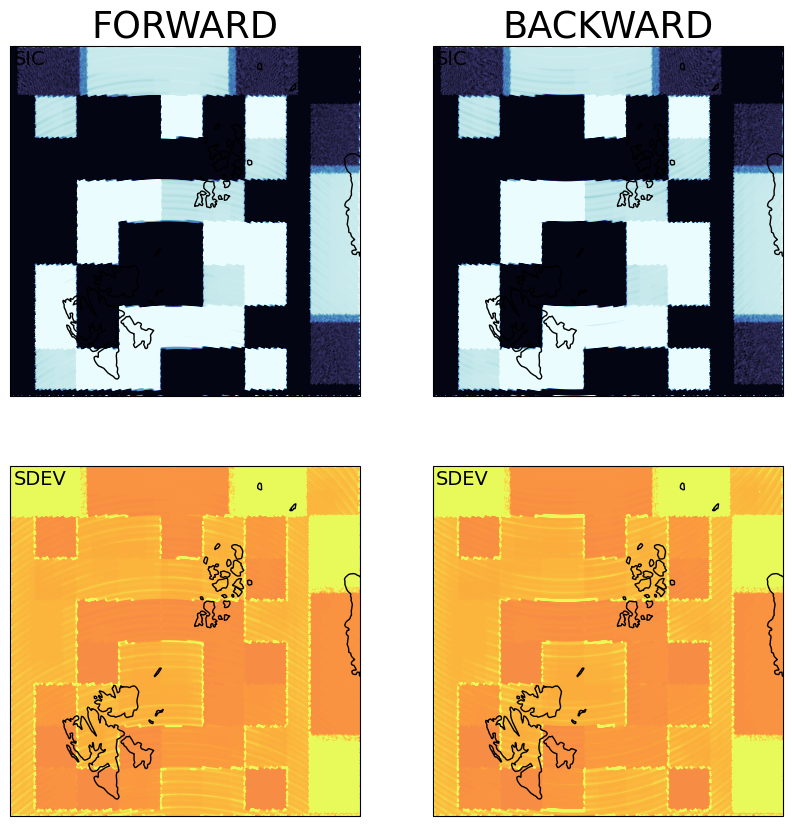

In [86]:
# visualization of the gridded fields
cmap = cmocean.cm.ice
ucmap = cmocean.cm.thermal
vmin, vmax = (0, 1)
umin, umax = (0, 10)

cart_crs = adef.to_cartopy_crs()
#cart_crs=ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10), subplot_kw=dict(projection=cart_crs))
# first row : SICs
ax[0,0].imshow(fwd_grd[algo].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
ax[0,0].coastlines()
ax[0,0].set_title('FORWARD')
ax[0,0].text(0.01,0.99,'SIC',va='top',fontsize=14,transform=ax[0,0].transAxes)
ax[0,1].imshow(bck_grd[algo].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
ax[0,1].coastlines()
ax[0,1].set_title('BACKWARD')
ax[0,1].text(0.01,0.99,'SIC',va='top',fontsize=14,transform=ax[0,1].transAxes)
# second row : SDEVs
ax[1,0].imshow(fwd_grd[algo].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
ax[1,0].coastlines()
ax[1,0].text(0.01,0.99,'SDEV',va='top',fontsize=14,transform=ax[1,0].transAxes)
ax[1,1].imshow(bck_grd[algo].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
ax[1,1].coastlines()
ax[1,1].text(0.01,0.99,'SDEV',va='top',fontsize=14,transform=ax[1,1].transAxes)

plt.show()

### Step 4.3 : Combine the forward and backward fields

In [87]:
# we call the result, the "merged" sic:
mrg_grd = dict()

# we do a naive merge (arithmetic mean) for now because the uncertainties
#   in forward and backward fields will be quite similar.
_mrg_grd_sic = 0.5 * (fwd_grd[algo].sic + bck_grd[algo].sic)

# the uncertainties in the forward and backward SIC fields are highly correlated,
#   thus at the first order the uncertainties are the mean uncertainty (in variance).
#   This should be revisited e.g. to reduce the uncertainty due to NeDT (which is small
#   wrt that due to tie-points).
_mrg_grd_var = 0.5 * (fwd_grd[algo].sdev**2 + bck_grd[algo].sdev**2)
_mrg_grd_sdev = _mrg_grd_var**0.5

# store in an object
mrg_grd[algo] = sic_algo.SICAlgoResult(_mrg_grd_sic, _mrg_grd_sdev, _grd_zeros, _grd_zeros)

# keep a flag to indicate where the forward and backward scans contributed
mrg_grd_flag = np.zeros(_mrg_grd_sic.shape, dtype='i8')
_fwd_valid = ~np.isnan(fwd_grd[algo].sic)
_bck_valid = ~np.isnan(bck_grd[algo].sic)
mrg_grd_flag[_fwd_valid] = 1
mrg_grd_flag[_bck_valid] = 2
mrg_grd_flag[_fwd_valid*_bck_valid] = 3

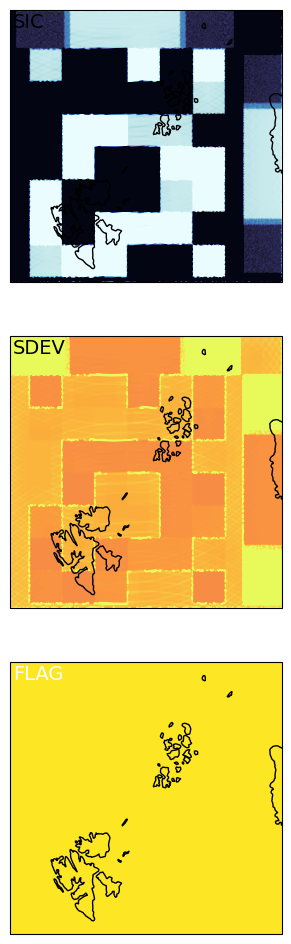

In [88]:
# visualize / plot
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(8,12), subplot_kw=dict(projection=cart_crs))
# first row : SICs
ax[0].imshow(mrg_grd[algo].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
ax[0].coastlines()
ax[0].text(0.01,0.99,'SIC',va='top',fontsize=14,transform=ax[0].transAxes)
# second row : SDEVs
ax[1].imshow(mrg_grd[algo].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
ax[1].coastlines()
ax[1].text(0.01,0.99,'SDEV',va='top',fontsize=14,transform=ax[1].transAxes)
# second row : FLAG
ax[2].imshow(mrg_grd_flag, transform=cart_crs, extent=cart_crs.bounds, origin='upper',vmin=0,vmax=3)
ax[2].coastlines()
ax[2].text(0.01,0.99,'FLAG',va='top',fontsize=14,transform=ax[2].transAxes,color='w')

plt.show()

## Step 5: Write Level-2 product file

We write a netCDF/CF files containing the merged SIC on the EASE2 2.5km grid. This requires a pre-processing of the SIC fields to apply the Open Water Filter, and separate the off-range SICs into specific variables.

Writing the netCDF/CF file is done via xarray.

### Step 5.1: Pre-processing of the SIC fields

TODO

### Step 5.2: Format L2 SIC file and write to disk

TODO

# Performance Evaluation